In [27]:
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.units as u
from astropy import wcs

In [28]:
# Importing the galaxy coordinates
df = pd.read_csv('Data_Files/Galaxies.csv')

# Making a new Density map

To make a density map from scratch, first we need to define the grid size of the map. The step variable will be the size of the pixels in the map.  <br />
Here the extent of the map is defined slighly larger than the extent of the data. 10% margins are added to the grid. <br />

In [29]:
step = 1/5 # step size for the grid in degrees
marg = 10 # margins for the grid in percentage

# Creating the grid
ra_min, ra_max = df['ra'].min(), df['ra'].max() 
dec_min, dec_max = df['dec'].min(), df['dec'].max()

ra_ext, dec_ext = ra_max-ra_min, dec_max-dec_min

grid_ra = np.arange(ra_min-ra_ext/marg, ra_max+ra_ext/marg, step) #Here we add a 10% margin to the grid 
grid_dec = np.arange(dec_min-dec_ext/marg, dec_max+dec_ext/marg, step)

ra_size, dec_size = grid_ra.shape[0], grid_dec.shape[0]

## Adding WCS to the map
Now, we have to create the World Coordinate System (WCS) for the map. The WCS is a standard for describing the position of a pixel in the sky. This ensures that the map has correct coordinates and projection <br />
The WCS created here is a simple sine projection, centered at the mid point of the grid and is created using `astropy` library. <br />
This way of creating wcs does not include information about dimensions of the map. We will add that in the next step. 

In [30]:
w = wcs.WCS(naxis=2)
# First we add the projection type
w.wcs.ctype = ["RA---SIN", "DEC--SIN"]
# Then the units of the coordinates
w.wcs.cunit = ["deg", "deg"]
# Now we set the center/reference pixel of the grid
w.wcs.crpix = [ra_size/2, dec_size/2] 
# This sets the value of the reference pixel in the same units as the coordinates
w.wcs.crval = [grid_ra[int(ra_size/2)], grid_dec[int(dec_size/2)]]
# This is the pixel scale in degrees. We take the difference between two adjacent pixels in the grid 
w.wcs.cdelt = np.array([(grid_ra[int(ra_size/2)]-grid_ra[int(ra_size/2)+1]), (grid_dec[int(dec_size/2)+1]-grid_dec[int(dec_size/2)])])
# More information avialable on astropy documentation
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 54.257543000000155  -35.9640859999999  
CRPIX : 55.0  35.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.20000000000000284  0.20000000000000284  
NAXIS : 0  0


In [31]:
# To add the size of the grid to the header
new_header = w.to_header().copy() # copy the header from the wcs object
new_header['NAXIS']=2
new_header['NAXIS1']=ra_size
new_header['NAXIS2']=dec_size
new_wcs = wcs.WCS(new_header) # create a new wcs object with the new header
# The new wcs has the same information as the old one, but with the NAXIS updated
print(new_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 54.257543  -35.964086  
CRPIX : 55.0  35.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.2  0.2  
NAXIS : 110  70


## Making density map
To create the density map, following steps are used: <br />
By going through each pixel that corresponds to a galaxy, the density of the pixel is then calculated by counting the number of data points within the region.

In [33]:
output_map_shape = (new_header['NAXIS1'], new_header['NAXIS2'])
print(output_map_shape)

(110, 70)


In [62]:
density = np.zeros(output_map_shape)
# Loop over the galaxies and add them to the grid
for i in range(len(df)):
    # Convert the world coordinates (ra, dec) to pixel coordinates
    app_ra, app_dec = new_wcs.world_to_pixel_values(df['ra'][i], df['dec'][i])
    # Round the pixel coordinates to the nearest integer
    pix_ra, pix_dec = int(np.rint(app_ra)), int(np.rint(app_dec))
    
    # Increment the density value at the corresponding pixel in the density map
    density[pix_ra,pix_dec] += 1

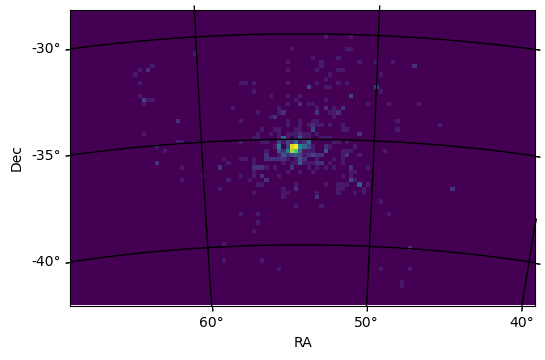

In [63]:
# Plot the density map
fig = plt.figure(1, figsize=(6, 6))
ax0 = plt.subplot(projection=new_wcs)
ra_ax = ax0.coords[0]
ra_ax.set_format_unit(unit='degree')

ax0.imshow(density.T)

ax0.set_xlabel('RA')
ax0.set_ylabel('Dec')
ax0.grid(color='black', lw=1)

### Saving the map as a fits file
The density map is saved as a fits file. Calculated density array is saved as the primary hdu of the fits file. The new_wcs is added as the header of the fits file.

In [66]:
hdu = fits.PrimaryHDU(density.T, new_header)
hdu.writeto('Data_Files/Output_Density_map.fits', overwrite=True)

## Extra information

### Using xray fits file for the output grid

If you wish to use grid and wcs from an existing fits file, you can  follow the steps below: <br />
1. Read the fits file using `astropy.io.fits` library. <br />
2. Extract the data and wcs from the fits file. <br />
3. Most of the time, the grid dimensions are very large and for making a density map, you might want to use larger pixels. This is done by binning. <br />
4. Loop through the data and calculate the density map as described above. 

In [68]:
ref_image_file = 'Data_Files/RXCJ0631.3-5610_m12pn.fits'
ref_image = fits.open(ref_image_file)[0]
ref_wcs = wcs.WCS(ref_image.header)

# Create empty 2D array for the output map
output_map_shape = (ref_image.header['NAXIS2'], ref_image.header['NAXIS1'])
output_map = np.zeros(output_map_shape)

print(ref_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 97.884125  -56.182  
CRPIX : 518.91  518.91  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000694444444444445  0.000694444444444445  
NAXIS : 1037  1037


Run the loop with these output_map dimensions and wcs. <br />
If you want to have larger pixels, you use following code to bin the data. Set the binning factor to the number you want. 

In [73]:
bin_f = 2 # binning factor
bin_header = ref_image.header.copy()

bin_header['NAXIS'] = 2
bin_header['NAXIS1'] = ref_image.header['NAXIS1']/bin_f
bin_header['NAXIS2'] = ref_image.header['NAXIS2']/bin_f
bin_header['CRPIX1'] = (ref_image.header['NAXIS1']/(2*bin_f))
bin_header['CRPIX2'] = (ref_image.header['NAXIS2']/(2*bin_f))
bin_header['CDELT1'] = ref_image.header['CDELT1']*bin_f
bin_header['CDELT2'] = ref_image.header['CDELT2']*bin_f

Use the new wcs and dimensions to create the density map.

### Different grid step and density map region

In the above codes, the grid step size is the same as extent of region used for calculating the density map.
Incase you want to have a difference in grid step and the region used for calculating the density map, you can use the following method. <br />
1. Create a new wcs with the desired grid step size. <br />
2. Use the new wcs to create a new grid. <br />
3. Use the `get_box_coords` function to get the calculate the extent of the region by setting it interms of pixels. <br />
4. Use this new extent to calculate the density map.

In [83]:
def get_box_coord(pix_ra, pix_dec, image_wcs, ext=3):
    """
    This function calculates the coordinates of a box around a pixel in an image.
    
    Parameters:
    pix_ra (float): Pixel coordinate in the x-axis.
    pix_dec (float): Pixel coordinate in the y-axis.
    image_wcs (astropy.wcs.WCS): WCS of the image.
    ext (int): Extent of the box in terms of pixels.
    
    Returns:
    tuple: A tuple containing the coordinates of the box (ra_prev, dec_prev, ra_next, dec_next).
    """
    ra_next = image_wcs.pixel_to_world(pix_ra+(ext/2), pix_dec).ra.value
    dec_next = image_wcs.pixel_to_world(pix_ra, pix_dec+(ext/2)).dec.value
    ra_prev = image_wcs.pixel_to_world(pix_ra-(ext/2), pix_dec).ra.value
    dec_prev = image_wcs.pixel_to_world(pix_ra, pix_dec-(ext/2)).dec.value
     
    # Sometimes the coordinates are in decrasing order, so we need to swap them
    if ra_next < ra_prev:
        ra_next, ra_prev = ra_prev, ra_next
    if dec_next < dec_prev:
        dec_next, dec_prev = dec_prev, dec_next
    return ra_prev, dec_prev, ra_next, dec_next

Use this function to obatin the density map as following: 

In [ ]:
density = np.zeros(output_map_shape)
# Loop over each pixel in the output map
for i in range(output_map_shape[0]):
    for j in range(output_map_shape[1]):
        # Get the coordinates of the box around the pixel
        ra_min, dec_min, ra_max, dec_max = get_box_coord(i, j, new_wcs) 
        # Create a mask that is True for rows in the dataframe where the 'ra' and 'dec' values are within the box
        mask = (df['ra']>=ra_min) & (df['ra']<=ra_max) & (df['dec']>=dec_min) & (df['dec']<=dec_max)
        # Count the number of True values in the mask and assign this to the corresponding element in the density array
        density[i,j] = mask.sum()